In [1]:
import pandas as pd
import numpy as np
import openpyxl
import os
import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

e:\Installation\Anaconda\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
e:\Installation\Anaconda\lib\site-packages\pandas\core\arrays\masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
def read_excel(file):
    df = pd.read_excel(file)
    return df

df_dmc = read_excel('../../Data/Processed data/lstm_dmc.xlsx')
df_square = read_excel('../../Data/Processed data/Square.xlsx')
df_popular = read_excel('../../Data/Processed data/popular medical.xlsx')
df_shomorita = read_excel('../../Data/Processed data/shomorita.xlsx')
df_anowarKhan = read_excel('../../Data/Processed data/Anowar Khan.xlsx')

In [3]:
def preprocess(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Date'] = df['Date'].values.astype(float)
    #sort by date
    df = df.sort_values(by='Date')
    # for rows where df['Affected'] is null or non-numeric, replace with 0
    df['Affected'] = pd.to_numeric(df['Affected'], errors='coerce').fillna(0).astype(float)
    df.reset_index(drop=True, inplace=True)
    return df

In [4]:
df_dmc = preprocess(df_dmc)
df_square = preprocess(df_square)
df_popular = preprocess(df_popular)
df_shomorita = preprocess(df_shomorita)
df_anowarKhan = preprocess(df_anowarKhan)

In [5]:
# coordinate of dmc is 23.726219241260043, 90.39761288327254
# coordinate of square is 23.753040178769584, 90.38158125443664
# coordinate of popular is 23.739355425694136, 90.38232134094551
# coordinate of shomorita is 23.752899859215965, 90.38514558141829
# coordinate of Anowar Khan is 23.745344649198245, 90.38221329676377

# make an array of coordinates

coordinates = np.array([[23.726219241260043, 90.39761288327254], [23.753040178769584, 90.38158125443664], [23.739355425694136, 90.38232134094551], [23.752899859215965, 90.38514558141829], [23.745344649198245, 90.38221329676377]])

In [6]:
# find distance between two coordinates
def distance(lat1, lon1, lat2, lon2):
    R = 6371
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2) * np.sin(dlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = R * c
    return d

In [7]:
# find distance between each pair of coordinates from coordinates array and save them in a new array
distances = []
for i in range(len(coordinates)):
    for j in range(i+1, len(coordinates)):
        distances.append(distance(coordinates[i][0], coordinates[i][1], coordinates[j][0], coordinates[j][1]))

In [8]:
# Make a graph of 5 nodes and connect each pair of nodes with an edge. The weight of each edge is the distance between the two nodes
import networkx as nx
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4])
G.add_edge(0, 1, weight=distances[0])
G.add_edge(0, 2, weight=distances[1])
G.add_edge(0, 3, weight=distances[2])
G.add_edge(0, 4, weight=distances[3])
G.add_edge(1, 2, weight=distances[4])
G.add_edge(1, 3, weight=distances[5])
G.add_edge(1, 4, weight=distances[6])
G.add_edge(2, 3, weight=distances[7])
G.add_edge(2, 4, weight=distances[8])
G.add_edge(3, 4, weight=distances[9])


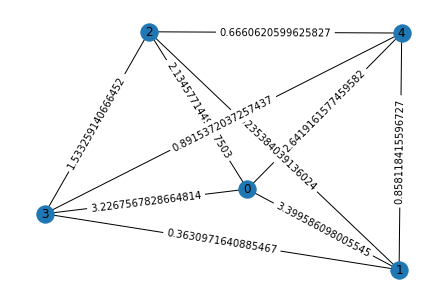

<Figure size 1440x720 with 0 Axes>

In [9]:
# plot the graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.figure(figsize=(20, 10))
plt.show()

In [10]:
# in df1, add a new 4 columns for distance from each hospital
df_dmc['Distance from square'] = 0
df_dmc['Distance from popular'] = 0
df_dmc['Distance from shomorita'] = 0
df_dmc['Distance from Anowar Khan'] = 0

df_dmc['Affected from square'] = 0
df_dmc['Affected from popular'] = 0
df_dmc['Affected from shomorita'] = 0
df_dmc['Affected from Anowar Khan'] = 0

# now populate the columns with distance from each hospital* the Affected value for same date in corresponding hospital
for i in range(len(df_dmc)):
    df_dmc['Distance from square'][i] = distance(23.726219241260043, 90.39761288327254, 23.753040178769584, 90.38158125443664) 
    df_dmc['Distance from popular'][i] = distance(23.726219241260043, 90.39761288327254, 23.739355425694136, 90.38232134094551) 
    df_dmc['Distance from shomorita'][i] = distance(23.726219241260043, 90.39761288327254, 23.752899859215965, 90.38514558141829) 
    df_dmc['Distance from Anowar Khan'][i] = distance(23.726219241260043, 90.39761288327254, 23.745344649198245, 90.38221329676377) 

for i in range(len(df_dmc)):
    df_dmc['Affected from square'][i] = df_square['Affected'][i]
    df_dmc['Affected from popular'][i] = df_popular['Affected'][i]
    df_dmc['Affected from shomorita'][i] = df_shomorita['Affected'][i]
    df_dmc['Affected from Anowar Khan'][i] = df_anowarKhan['Affected'][i]

C:\Users\aniki\AppData\Local\Temp/ipykernel_15568/3495085650.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dmc['Distance from square'][i] = distance(23.726219241260043, 90.39761288327254, 23.753040178769584, 90.38158125443664)
C:\Users\aniki\AppData\Local\Temp/ipykernel_15568/3495085650.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '3.399586098005545' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_dmc['Distance from square'][i] = distance(23.726219241260043, 90.39761288327254, 23.753040178769584, 90.38158125443664)
C:\Users\aniki\AppData\Local\Temp/ipykernel_15568/3495085650.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame


In [11]:
# delete last four columns from df_dmc
# df_dmc = df_dmc.drop(columns=['Distance from square', 'Distance from popular', 'Distance from shomorita', 'Distance from Anowar Khan'])
df_dmc.head()

,Date,Affected,Distance from square,Distance from popular,Distance from shomorita,Distance from Anowar Khan,Affected from square,Affected from popular,Affected from shomorita,Affected from Anowar Khan
0,1.567296e+18,92.0,3.399586,2.134577,3.226757,2.641916,2,3,1,2
1,1.567382e+18,82.0,3.399586,2.134577,3.226757,2.641916,9,3,0,4
2,1.567469e+18,64.0,3.399586,2.134577,3.226757,2.641916,2,4,0,4
3,1.567555e+18,47.0,3.399586,2.134577,3.226757,2.641916,5,1,0,1
4,1.567642e+18,63.0,3.399586,2.134577,3.226757,2.641916,3,4,0,4


In [12]:
# #normalize the distaances from zero to one where closer distance will have higher value
# df_dmc['Distance from square'] = (df_dmc['Distance from square'] - df_dmc['Distance from square'].min()) / (df_dmc['Distance from square'].max() - df_dmc['Distance from square'].min())
# df_dmc['Distance from popular'] = (df_dmc['Distance from popular'] - df_dmc['Distance from popular'].min()) / (df_dmc['Distance from popular'].max() - df_dmc['Distance from popular'].min())
# df_dmc['Distance from shomorita'] = (df_dmc['Distance from shomorita'] - df_dmc['Distance from shomorita'].min()) / (df_dmc['Distance from shomorita'].max() - df_dmc['Distance from shomorita'].min()) 
# df_dmc['Distance from Anowar Khan'] = (df_dmc['Distance from Anowar Khan'] - df_dmc['Distance from Anowar Khan'].min()) / (df_dmc['Distance from Anowar Khan'].max() - df_dmc['Distance from Anowar Khan'].min())

In [13]:
square_distance = df_dmc['Distance from square'].max()
popular_distance = df_dmc['Distance from popular'].max()
shomorita_distance = df_dmc['Distance from shomorita'].max()
Anowar_Khan_distance = df_dmc['Distance from Anowar Khan'].max()

print(square_distance, popular_distance, shomorita_distance, Anowar_Khan_distance)

df_dmc['Distance from square'] = square_distance/ (square_distance + popular_distance + shomorita_distance + Anowar_Khan_distance)
df_dmc['Distance from popular'] = popular_distance/ (square_distance + popular_distance + shomorita_distance + Anowar_Khan_distance)
df_dmc['Distance from shomorita'] = shomorita_distance/ (square_distance + popular_distance + shomorita_distance + Anowar_Khan_distance)
df_dmc['Distance from Anowar Khan'] = Anowar_Khan_distance/ (square_distance + popular_distance + shomorita_distance + Anowar_Khan_distance)

3.399586098005545 2.1345771449067503 3.2267567828664814 2.6419161577459582


In [14]:
df_dmc.head()

,Date,Affected,Distance from square,Distance from popular,Distance from shomorita,Distance from Anowar Khan,Affected from square,Affected from popular,Affected from shomorita,Affected from Anowar Khan
0,1.567296e+18,92.0,0.298135,0.187197,0.282978,0.231689,2,3,1,2
1,1.567382e+18,82.0,0.298135,0.187197,0.282978,0.231689,9,3,0,4
2,1.567469e+18,64.0,0.298135,0.187197,0.282978,0.231689,2,4,0,4
3,1.567555e+18,47.0,0.298135,0.187197,0.282978,0.231689,5,1,0,1
4,1.567642e+18,63.0,0.298135,0.187197,0.282978,0.231689,3,4,0,4


In [15]:
df_dmc['Distance from square'] = 1 - df_dmc['Distance from square']
df_dmc['Distance from popular'] = 1 - df_dmc['Distance from popular']
df_dmc['Distance from shomorita'] = 1 - df_dmc['Distance from shomorita']
df_dmc['Distance from Anowar Khan'] = 1 - df_dmc['Distance from Anowar Khan']

df_dmc.head()

,Date,Affected,Distance from square,Distance from popular,Distance from shomorita,Distance from Anowar Khan,Affected from square,Affected from popular,Affected from shomorita,Affected from Anowar Khan
0,1.567296e+18,92.0,0.701865,0.812803,0.717022,0.768311,2,3,1,2
1,1.567382e+18,82.0,0.701865,0.812803,0.717022,0.768311,9,3,0,4
2,1.567469e+18,64.0,0.701865,0.812803,0.717022,0.768311,2,4,0,4
3,1.567555e+18,47.0,0.701865,0.812803,0.717022,0.768311,5,1,0,1
4,1.567642e+18,63.0,0.701865,0.812803,0.717022,0.768311,3,4,0,4


In [16]:
square_distance = df_dmc['Distance from square'].max()
popular_distance = df_dmc['Distance from popular'].max()
shomorita_distance = df_dmc['Distance from shomorita'].max()
Anowar_Khan_distance = df_dmc['Distance from Anowar Khan'].max()

df_dmc['Distance from square'] = square_distance/ (square_distance + popular_distance + shomorita_distance + Anowar_Khan_distance)
df_dmc['Distance from popular'] = popular_distance/ (square_distance + popular_distance + shomorita_distance + Anowar_Khan_distance)
df_dmc['Distance from shomorita'] = shomorita_distance/ (square_distance + popular_distance + shomorita_distance + Anowar_Khan_distance)
df_dmc['Distance from Anowar Khan'] = Anowar_Khan_distance/ (square_distance + popular_distance + shomorita_distance + Anowar_Khan_distance)

df_dmc.head()

,Date,Affected,Distance from square,Distance from popular,Distance from shomorita,Distance from Anowar Khan,Affected from square,Affected from popular,Affected from shomorita,Affected from Anowar Khan
0,1.567296e+18,92.0,0.233955,0.270934,0.239007,0.256104,2,3,1,2
1,1.567382e+18,82.0,0.233955,0.270934,0.239007,0.256104,9,3,0,4
2,1.567469e+18,64.0,0.233955,0.270934,0.239007,0.256104,2,4,0,4
3,1.567555e+18,47.0,0.233955,0.270934,0.239007,0.256104,5,1,0,1
4,1.567642e+18,63.0,0.233955,0.270934,0.239007,0.256104,3,4,0,4


In [17]:
df_dmc['Affected from square'] = df_dmc['Affected from square'] * df_dmc['Distance from square']
df_dmc['Affected from popular'] = df_dmc['Affected from popular'] * df_dmc['Distance from popular']
df_dmc['Affected from shomorita'] = df_dmc['Affected from shomorita'] * df_dmc['Distance from shomorita']
df_dmc['Affected from Anowar Khan'] = df_dmc['Affected from Anowar Khan'] * df_dmc['Distance from Anowar Khan']

df_dmc.head()

,Date,Affected,Distance from square,Distance from popular,Distance from shomorita,Distance from Anowar Khan,Affected from square,Affected from popular,Affected from shomorita,Affected from Anowar Khan
0,1.567296e+18,92.0,0.233955,0.270934,0.239007,0.256104,0.467910,0.812803,0.239007,0.512207
1,1.567382e+18,82.0,0.233955,0.270934,0.239007,0.256104,2.105595,0.812803,0.000000,1.024414
2,1.567469e+18,64.0,0.233955,0.270934,0.239007,0.256104,0.467910,1.083737,0.000000,1.024414
3,1.567555e+18,47.0,0.233955,0.270934,0.239007,0.256104,1.169775,0.270934,0.000000,0.256104
4,1.567642e+18,63.0,0.233955,0.270934,0.239007,0.256104,0.701865,1.083737,0.000000,1.024414


In [18]:
# add all the affected values from each hospital and save it in a new column
df_dmc['Total Affected Nearby'] = df_dmc['Affected from square'] + df_dmc['Affected from popular'] + df_dmc['Affected from shomorita'] + df_dmc['Affected from Anowar Khan']

df_dmc.head()

,Date,Affected,Distance from square,Distance from popular,Distance from shomorita,Distance from Anowar Khan,Affected from square,Affected from popular,Affected from shomorita,Affected from Anowar Khan,Total Affected Nearby
0,1.567296e+18,92.0,0.233955,0.270934,0.239007,0.256104,0.467910,0.812803,0.239007,0.512207,2.031927
1,1.567382e+18,82.0,0.233955,0.270934,0.239007,0.256104,2.105595,0.812803,0.000000,1.024414,3.942812
2,1.567469e+18,64.0,0.233955,0.270934,0.239007,0.256104,0.467910,1.083737,0.000000,1.024414,2.576061
3,1.567555e+18,47.0,0.233955,0.270934,0.239007,0.256104,1.169775,0.270934,0.000000,0.256104,1.696813
4,1.567642e+18,63.0,0.233955,0.270934,0.239007,0.256104,0.701865,1.083737,0.000000,1.024414,2.810016


In [19]:
# drop all the columns except 'Date'. 'Affected' and 'Total Affected Nearby'

df_dmc = df_dmc.drop(columns=['Distance from square', 'Distance from popular', 'Distance from shomorita', 'Distance from Anowar Khan', 'Affected from square', 'Affected from popular', 'Affected from shomorita', 'Affected from Anowar Khan'])

df_dmc.head()

,Date,Affected,Total Affected Nearby
0,1.567296e+18,92.0,2.031927
1,1.567382e+18,82.0,3.942812
2,1.567469e+18,64.0,2.576061
3,1.567555e+18,47.0,1.696813
4,1.567642e+18,63.0,2.810016


In [20]:
# defining hyperparameters
num_epochs = 500
learning_rate = 0.001
batch_size = 32
input_size = 14
prediction_window = 5
window_size = input_size + prediction_window
hidden_size = 64
num_layers = 1


print("num_epochs: ", num_epochs, " learning_rate: ", learning_rate, " batch_size: ", batch_size, " window_size: ", window_size, " input_size: ", input_size, " num_layers: ", num_layers)

num_epochs:  500  learning_rate:  0.001  batch_size:  32  window_size:  19  input_size:  14  num_layers:  1


In [21]:
def create_time_series_samples(df, window_size):
    samples = []

    for i in range(len(df) - window_size + 1):
        sample = df.iloc[i:i + window_size]
        samples.append(sample)

    return samples

samples = create_time_series_samples(df_dmc, window_size)

In [22]:
samples[0]

,Date,Affected,Total Affected Nearby
0,1.567296e+18,92.0,2.031927
1,1.567382e+18,82.0,3.942812
2,1.567469e+18,64.0,2.576061
3,1.567555e+18,47.0,1.696813
4,1.567642e+18,63.0,2.810016
5,1.567728e+18,61.0,0.783141
6,1.567814e+18,33.0,1.499837
7,1.567901e+18,52.0,1.430931
8,1.568074e+18,81.0,1.339841
9,1.568160e+18,49.0,0.797972


In [23]:
#drop the 'Date' column from each sample
samples = [sample.drop(columns=['Date']) for sample in samples]

samples[0]

,Affected,Total Affected Nearby
0,92.0,2.031927
1,82.0,3.942812
2,64.0,2.576061
3,47.0,1.696813
4,63.0,2.810016
5,61.0,0.783141
6,33.0,1.499837
7,52.0,1.430931
8,81.0,1.339841
9,49.0,0.797972


In [24]:
#convert two columns to one column by concatenating them one after another for samples[0]
sample = samples[0].values.reshape(-1)
print(sample)

# do the same for all the samples
samples = [sample.values.reshape(-1) for sample in samples]


[92.          2.03192713 82.          3.94281171 64.          2.57606134
 47.          1.69681263 63.          2.8100163  61.          0.78314139
 33.          1.49983704 52.          1.43093054 81.          1.33984082
 49.          0.79797218 51.          0.49005849 40.          0.71196933
 34.          1.03192713 36.          0.23395496 39.          0.49005849
 46.          1.80775073 47.          1.49983704 35.          0.25610354
 40.          0.72401345]


In [25]:
# now make each sample a dataframe

samples = [pd.DataFrame(sample) for sample in samples]

samples[0]

,0
0,92.000000
1,2.031927
2,82.000000
3,3.942812
4,64.000000
5,2.576061
6,47.000000
7,1.696813
8,63.000000
9,2.810016


In [26]:
# make a dataframe of all the samples
samples = pd.concat(samples, axis=1).T

samples.head()

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,92.0,2.031927,82.0,3.942812,64.0,2.576061,47.0,1.696813,63.0,2.810016,...,39.0,0.490058,46.0,1.807751,47.0,1.499837,35.0,0.256104,40.0,0.724013
0,82.0,3.942812,64.0,2.576061,47.0,1.696813,63.0,2.810016,61.0,0.783141,...,46.0,1.807751,47.0,1.499837,35.0,0.256104,40.0,0.724013,35.0,0.812803
0,64.0,2.576061,47.0,1.696813,63.0,2.810016,61.0,0.783141,33.0,1.499837,...,47.0,1.499837,35.0,0.256104,40.0,0.724013,35.0,0.812803,19.0,0.233955
0,47.0,1.696813,63.0,2.810016,61.0,0.783141,33.0,1.499837,52.0,1.430931,...,35.0,0.256104,40.0,0.724013,35.0,0.812803,19.0,0.233955,36.0,0.233955
0,63.0,2.810016,61.0,0.783141,33.0,1.499837,52.0,1.430931,81.0,1.339841,...,40.0,0.724013,35.0,0.812803,19.0,0.233955,36.0,0.233955,37.0,0.000000


In [27]:
# if any cell is null, replace it with 0
samples = samples.fillna(0)

In [28]:
samples.head()

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,92.0,2.031927,82.0,3.942812,64.0,2.576061,47.0,1.696813,63.0,2.810016,...,39.0,0.490058,46.0,1.807751,47.0,1.499837,35.0,0.256104,40.0,0.724013
0,82.0,3.942812,64.0,2.576061,47.0,1.696813,63.0,2.810016,61.0,0.783141,...,46.0,1.807751,47.0,1.499837,35.0,0.256104,40.0,0.724013,35.0,0.812803
0,64.0,2.576061,47.0,1.696813,63.0,2.810016,61.0,0.783141,33.0,1.499837,...,47.0,1.499837,35.0,0.256104,40.0,0.724013,35.0,0.812803,19.0,0.233955
0,47.0,1.696813,63.0,2.810016,61.0,0.783141,33.0,1.499837,52.0,1.430931,...,35.0,0.256104,40.0,0.724013,35.0,0.812803,19.0,0.233955,36.0,0.233955
0,63.0,2.810016,61.0,0.783141,33.0,1.499837,52.0,1.430931,81.0,1.339841,...,40.0,0.724013,35.0,0.812803,19.0,0.233955,36.0,0.233955,37.0,0.000000


In [29]:
# delete every 2nd row from samples i.e 2nd row, 4th row, 6th row, 8th row, etc
samples = samples.iloc[::2]

samples.head()

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,92.0,2.031927,82.0,3.942812,64.0,2.576061,47.0,1.696813,63.0,2.810016,...,39.0,0.490058,46.0,1.807751,47.0,1.499837,35.0,0.256104,40.0,0.724013
0,64.0,2.576061,47.0,1.696813,63.0,2.810016,61.0,0.783141,33.0,1.499837,...,47.0,1.499837,35.0,0.256104,40.0,0.724013,35.0,0.812803,19.0,0.233955
0,63.0,2.810016,61.0,0.783141,33.0,1.499837,52.0,1.430931,81.0,1.339841,...,40.0,0.724013,35.0,0.812803,19.0,0.233955,36.0,0.233955,37.0,0.000000
0,33.0,1.499837,52.0,1.430931,81.0,1.339841,49.0,0.797972,51.0,0.490058,...,19.0,0.233955,36.0,0.233955,37.0,0.000000,37.0,0.775824,30.0,0.270934
0,81.0,1.339841,49.0,0.797972,51.0,0.490058,40.0,0.711969,34.0,1.031927,...,37.0,0.000000,37.0,0.775824,30.0,0.270934,25.0,0.512207,15.0,0.541869


In [30]:
input_size = input_size * 2
prediction_window = prediction_window * 2
window_size = input_size + prediction_window

In [31]:
def train_test_split(df, split_ratio, shuffle):
    if shuffle:
        df = df.sample(frac=1)

    split_index = int(len(df) * split_ratio)
    train = df[:split_index]
    test = df[split_index:]

    return train, test

train_df , test_df = train_test_split(samples, 0.8, False)

In [32]:
def split_X_y(df):
    #last prediction_window columns are y
    y = df.iloc[:, -prediction_window:]
    #first window_size - prediction_window columns are X
    X = df.iloc[:, :input_size]
    return X, y

X_train, y_train = split_X_y(train_df)
X_test, y_test = split_X_y(test_df)

In [33]:
print("X_train.shape: ", X_train.shape, " y_train.shape: ", y_train.shape, " X_test.shape: ", X_test.shape, " y_test.shape: ", y_test.shape)

X_train.shape:  (272, 28)  y_train.shape:  (272, 10)  X_test.shape:  (68, 28)  y_test.shape:  (68, 10)


In [34]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)

X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [35]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, prediction_window)  

    def forward(self, x):
        h_t, _ = self.lstm(x)
        output = self.fc(h_t[:, -1, :]) 
        return output

In [36]:
model = LSTMModel(input_size, hidden_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [37]:
train_losses = np.zeros(num_epochs)

for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        inputs = inputs.unsqueeze(1)
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    train_losses[epoch] = loss.item()

Epoch [1/500], Loss: 86.4855
Epoch [2/500], Loss: 271.5518
Epoch [3/500], Loss: 71.9977
Epoch [4/500], Loss: 224.0541
Epoch [5/500], Loss: 338.2579
Epoch [6/500], Loss: 312.4817
Epoch [7/500], Loss: 102.9637
Epoch [8/500], Loss: 257.1543
Epoch [9/500], Loss: 387.7357
Epoch [10/500], Loss: 338.3977
Epoch [11/500], Loss: 27.3387
Epoch [12/500], Loss: 190.1641
Epoch [13/500], Loss: 108.8735
Epoch [14/500], Loss: 282.3826


Epoch [15/500], Loss: 108.4512
Epoch [16/500], Loss: 319.4729
Epoch [17/500], Loss: 120.0076
Epoch [18/500], Loss: 95.9348
Epoch [19/500], Loss: 163.4893
Epoch [20/500], Loss: 264.3824
Epoch [21/500], Loss: 184.1485
Epoch [22/500], Loss: 181.6900
Epoch [23/500], Loss: 59.9779
Epoch [24/500], Loss: 447.2753
Epoch [25/500], Loss: 216.6776
Epoch [26/500], Loss: 137.2795
Epoch [27/500], Loss: 196.0321
Epoch [28/500], Loss: 67.9658
Epoch [29/500], Loss: 157.8382
Epoch [30/500], Loss: 24.6279
Epoch [31/500], Loss: 409.7043
Epoch [32/500], Loss: 144.9956
Epoch [33/500], Loss: 367.3969
Epoch [34/500], Loss: 293.9597
Epoch [35/500], Loss: 236.9691
Epoch [36/500], Loss: 61.5452
Epoch [37/500], Loss: 15.9954
Epoch [38/500], Loss: 271.1231
Epoch [39/500], Loss: 45.8374
Epoch [40/500], Loss: 394.1157
Epoch [41/500], Loss: 104.4226
Epoch [42/500], Loss: 345.7924
Epoch [43/500], Loss: 150.5943
Epoch [44/500], Loss: 7.9736
Epoch [45/500], Loss: 88.1679
Epoch [46/500], Loss: 156.2082
Epoch [47/500], Lo

In [38]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor.unsqueeze(1))
    test_loss = criterion(test_outputs.squeeze(), y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

predictions = test_outputs.numpy()

Test Loss: 235.2711


In [39]:
#get the first column of the test set
y_test_1 = y_test[:, 0]
y_test_2 = y_test[:, 1]
# y_test_3 = y_test[:, 2]

# #get the first column of the predictions
predictions_1 = predictions[:, 0]
predictions_2 = predictions[:, 1]
# predictions_3 = predictions[:, 2]

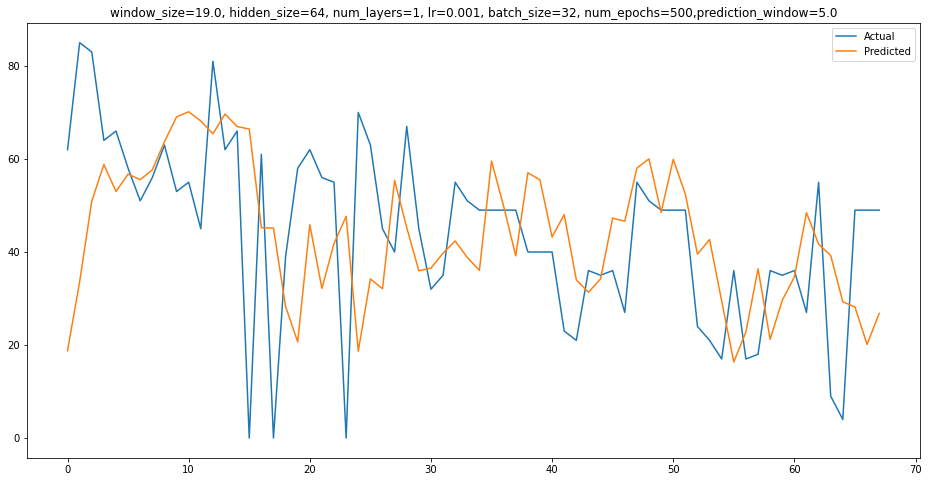

In [40]:
plt.figure(figsize=(16,8))
plt.title(f'window_size={window_size/2}, hidden_size={hidden_size}, num_layers={num_layers}, lr={learning_rate}, batch_size={batch_size}, num_epochs={num_epochs},prediction_window={prediction_window/2}')
plt.plot(y_test_1, label='Actual')
plt.plot(predictions_1, label='Predicted')
plt.legend()
plt.show()

In [41]:
# test loss on MAE, MSE, RMSE
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("Mean Absolute Error: ", mean_absolute_error(y_test_1, predictions_1))
print("Mean Squared Error: ", mean_squared_error(y_test_1, predictions_1))
print("Root Mean Squared Error: ", np.sqrt(mean_squared_error(y_test_1, predictions_1)))

Mean Absolute Error:  16.610666415270636
Mean Squared Error:  465.2105931192488
Root Mean Squared Error:  21.56874111113694
